In [5]:
import pandas as pd 
import numpy as np
import warnings
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from regpyhdfe import Regpyhdfe
from linearmodels.iv import absorbing
warnings.simplefilter(action='ignore')

### Figure 5

In [154]:
def figure5(dgpr_vendors,n,drawing_style):
    # ------------------------------------------------
    # This function will take dgpr_vendors dataset and output an image to show the Top n Winners in the market share due to
    # the DGPR and the Top n Loasers in the market share due to the DGPR.
    # Inputs: 
    #    dgpr_vendors dataset: dataset
    #    n:  (int) indicated how many firms you would like to see in chart from top to bottom that win/losethe most
    #    drawing_style: ([(linestyle,marker)]) list of n tuples that can used to indicate firm when drawing
    # Output: Figure 5 Graph
    # ---------------------------------------------------
    # bys tracker_firm date: keep if _n==1
    dgpr_vendors1 =dgpr_vendors.sort_values(by=['tracker_firm','date'])
    dgpr_vendors2 = dgpr_vendors1.groupby(['tracker_firm','date'],as_index=False).agg(date=('date','first'),
                                                                                  tracker_firm=('tracker_firm','first'),
                                                                                    ms_websites_firm=('ms_websites_firm','first'))
    
    # gen after=date>=td(25may2018)
    dgpr_vendors2['after']=np.where(dgpr_vendors2['date']>np.datetime64('2018-05-25'), 1,0 )
    
    # bys tracker_firm after: egen avg_ms=mean(ms_websites_firm) and keep if _n==1
    dgpr_vendors2 = dgpr_vendors2.sort_values(by=['tracker_firm','after'])
    dgpr_vendors3 = dgpr_vendors2.groupby(['tracker_firm','after'],as_index=False).agg(
                                                                                        tracker_firm=('tracker_firm','first'),
                                                                                        avg_ms=('ms_websites_firm','mean'),
                                                                                        after = ('after','first'))
    # bys tracker_firm: gen dms =avg_ms-avg_ms[_n-1]
    dgpr_vendors3['dms'] = [0] + [dgpr_vendors3.avg_ms[i]- dgpr_vendors3.avg_ms[i-1] for i in range(1,(len(dgpr_vendors3)))]
    dgpr_vendors3.loc[dgpr_vendors3['after']==0,'dms']=0
    
    # keep if after ==1
    dgpr_vendors4 = dgpr_vendors3[dgpr_vendors3['after']==1]
    
    # gen minus=dms<0
    dgpr_vendors4['minus'] = np.where(dgpr_vendors4['dms']<0, 1,0 )
    
    # gen absd=abs(dms)
    dgpr_vendors4['absd'] = abs(dgpr_vendors4['dms'])
    
    
    # egen rank_plus=rank(absd) if minus==0
    dgpr_vendors4['rank_plus']=0
    dgpr_vendors4.loc[dgpr_vendors4['minus']==0,'rank_plus']=dgpr_vendors4[dgpr_vendors4['minus']==0]['absd'].rank(method='max')
    
    
    # egen rank_minus=rank(absd) if minus ==1
    dgpr_vendors4['rank_minus']=0
    dgpr_vendors4.loc[dgpr_vendors4['minus']==1,'rank_minus']=dgpr_vendors4[dgpr_vendors4['minus']==1]['absd'].rank(method='max')
    
    # replace rank_plus=r(max) - rank_plus+1
    dgpr_vendors4['rank_plus'] = dgpr_vendors4['rank_plus'].max()-dgpr_vendors4['rank_plus']+1
    
    
    #replace rank_minus=r(max) -rank_minus+1
    dgpr_vendors4['rank_minus']=dgpr_vendors4['rank_minus'].max()-dgpr_vendors4['rank_minus']+1
    
    # merge 1:m tracker_firm using "gdpr_vendors.dta"
    processed_dgpr_vendors1=dgpr_vendors1.merge(dgpr_vendors4[['tracker_firm','rank_plus','rank_minus']],on='tracker_firm',how='left')
    
    # Keep date tracker_firm ms_websites_firm rank_plus rank_minus
    processed_dgpr_vendors1_clean = processed_dgpr_vendors1[['date','tracker_firm','ms_websites_firm','rank_plus','rank_minus']]
    
    # bys tracker_firm date: keep if _n=1
    processed_dgpr_vendors1_clean = processed_dgpr_vendors1_clean.sort_values(by=['tracker_firm','date'])
    processed_dgpr_vendors1_clean1=processed_dgpr_vendors1_clean.groupby(['tracker_firm','date'],as_index=False).agg(
        date=('date','first'),tracker_firm=('tracker_firm','first'),ms_websites_firm=('ms_websites_firm','first'),
        rank_plus=('rank_plus','first'),rank_minus=('rank_minus','first'))
    
    # gen byte basedate = 1 if date ==td(15may2018)
    processed_dgpr_vendors1_clean1['basedate']=np.where(processed_dgpr_vendors1_clean1['date']==np.datetime64('2018-05-15'), 1,0 )
    
    # bysort tracker_firm (basedate) : gen ms_firm_change = (ms_websites_firm - ms_websites_firm[1])
    processed_dgpr_vendors1_clean1 = processed_dgpr_vendors1_clean1.sort_values(
        by=['tracker_firm','basedate'],ascending=[True, False])
    basedata=processed_dgpr_vendors1_clean1[processed_dgpr_vendors1_clean1['basedate']==1][['tracker_firm','ms_websites_firm']]
    processed_dgpr_vendors1_clean2=processed_dgpr_vendors1_clean1.merge(
        basedata,on='tracker_firm',how='left').rename(
        columns={'ms_websites_firm_x':'ms_websites_firm','ms_websites_firm_y': 'ms_websites_base'})
    processed_dgpr_vendors1_clean2['ms_firm_change']=[processed_dgpr_vendors1_clean2.ms_websites_firm[i]- 
                                                      processed_dgpr_vendors1_clean2.ms_websites_base[i] 
                                                      for i in range(0,(len(processed_dgpr_vendors1_clean2)))]
    
    # Plot Winners Chart
    winner_df = processed_dgpr_vendors1_clean2[processed_dgpr_vendors1_clean2['rank_plus']<(n+1)].sort_values(by=['rank_plus']).reset_index()
    winner_firm_order = winner_df['tracker_firm'].unique()
    winner_df = winner_df[['date','tracker_firm','ms_firm_change']]
    winner_plot_df=winner_df.pivot(index='date', columns='tracker_firm', values='ms_firm_change')
    for firm,(line,mark) in zip(winner_firm_order,drawing_style):
        plt.plot(winner_plot_df[firm],label=firm,linestyle=line,marker=mark)
    plt.axhline(y = 0)
    plt.axvline(x = np.datetime64('2018-05-15'),linestyle="--")
    plt.tick_params(axis='x', labelsize=8)
    plt.yticks(np.arange(-1, 1.2,0.5))
    plt.ylim([-1.2, 1.2])
    plt.xticks(np.arange(np.datetime64('2017-04'), np.datetime64('2018-12'),np.timedelta64(6, 'M')))
    plt.xlim([np.datetime64('2017-04-01'),np.datetime64('2018-12-01')])
    plt.title(f"Top {n} Winners")
    plt.legend(loc='best')
    plt.show()
    
    # Plot Loser Chart
    loser_df = processed_dgpr_vendors1_clean2[processed_dgpr_vendors1_clean2['rank_minus']<(n+1)].sort_values(
        by=['rank_minus']).reset_index()
    loser_firm_order = loser_df['tracker_firm'].unique()
    loser_df = loser_df[['date','tracker_firm','ms_firm_change']]
    loser_plot_df=loser_df.pivot(index='date', columns='tracker_firm', values='ms_firm_change')
    for firm,(line,mark) in zip(loser_firm_order,drawing_style):
        plt.plot(loser_plot_df[firm],label=firm,linestyle=line,marker=mark)
    plt.axhline(y = 0)
    plt.axvline(x = np.datetime64('2018-05-15'),linestyle="--")
    plt.tick_params(axis='x', labelsize=8)
    plt.yticks(np.arange(-0.2, 0.7,0.2))
    plt.ylim([-0.3, 0.7])
    plt.xticks(np.arange(np.datetime64('2017-04'), np.datetime64('2018-12'),np.timedelta64(6, 'M')))
    plt.xlim([np.datetime64('2017-04-01'),np.datetime64('2018-12-01')])
    plt.title(f"Top {n} Losers")
    plt.legend(loc='best')
    plt.show()

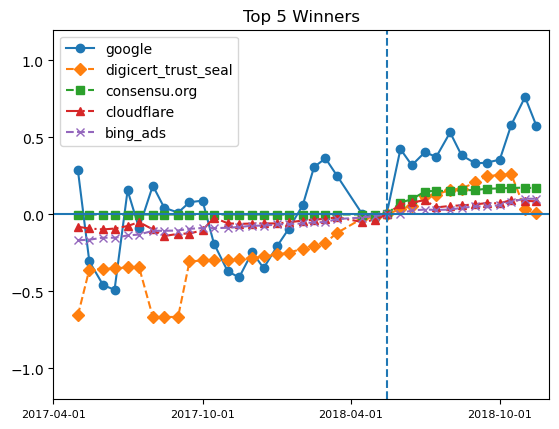

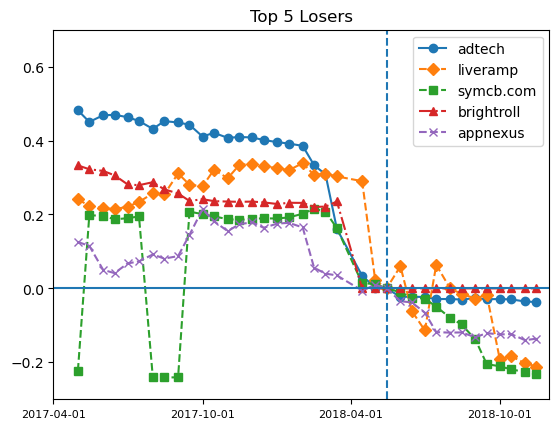

In [155]:
# Execute Example:
# Settings
dgpr_vendors=pd.read_stata("..\mksc.2021.1339\data\gdpr_vendors.dta")
n=5
drawing_style=[("-","o"),("--","D"),("--","s"),("-.","^"),("--","x")]
figure5(dgpr_vendors,n,drawing_style)

### Table 7

In [48]:
def table7(dgpr_vendors):
    # ------------------------------------------------
    # This function will take dgpr_vendors dataset and output the table (7) to show the change in Market Structure 
    # of the Web Technology Industry
    # Inputs: 
    #    dgpr_vendors dataset: dataset
    # Output: Table 7
    # ---------------------------------------------------
    
    
    # bys tracker_firm date: keep if _n==1
    result_table={}
    result_table["row_name"]=["After","(std err)","Observations","Pre-GDPR mean"]
    
    
    ## ---------------------- HHI All--------------------------------
    # collapse (sum) ms_websites_firm=ms_websites, by (tracker_firm date) fast
    dgpr_vendors1 = dgpr_vendors.groupby(['tracker_firm','date'],as_index=False).agg(date=('date','first'),
                                                                tracker_firm=('tracker_firm','first'),
                                                                ms_websites_firm=('ms_websites','sum'))
    # gen ms_websites_firm2=ms_websites_firm^2
    dgpr_vendors1['ms_websites_firm2'] = dgpr_vendors1['ms_websites_firm']**2
    
    # collapse (sum) hhi=ms_websites_firm2, by (date) fast
    dgpr_vendors2 = dgpr_vendors1.groupby(['date'],as_index=False).agg(date=('date','first'),
                                                                    hhi=('ms_websites_firm2','sum'))

    # gen after=date>td(25may2018)
    dgpr_vendors2['after']=np.where(dgpr_vendors2['date']>np.datetime64('2018-05-25'), 1,0 )
    
    # su date
    # gen trend=(date-r(min)+1)/100
    dgpr_vendors2['trend']=(dgpr_vendors2['date']- dgpr_vendors2['date'].min()+np.timedelta64(1, 'D'))/np.timedelta64(100, 'D')
    
    # su date if after==1
    # gen trend_after=(date-r(min)+1)/100
    dgpr_vendors2['trend_after']=0
    dgpr_vendors2.loc[dgpr_vendors2['after']==1,'trend_after']=(dgpr_vendors2.loc[
        dgpr_vendors2['after']==1,'date']-dgpr_vendors2.loc[dgpr_vendors2['after']==1,'date'].min()+
                                                                np.timedelta64(1, 'D'))/np.timedelta64(100, 'D')
    
    # eststo m_requests_g: reg hhi trend after c.trend_after#c.after, robust
    m_requests_g_all = smf.ols("hhi ~ trend + after + trend_after*after", data=dgpr_vendors2).fit(cov_type='HC1')
    m_requests_g_all.summary().tables[1]
    result_for_all = pd.read_html(m_requests_g_all.summary().tables[1].as_html(), header=0, index_col=0)[0]
    result_table["HHI all"]=[result_for_all.loc["after","coef"].round(3),result_for_all.loc["after","std err"].round(3),
                             f"{len(dgpr_vendors2)}",round(dgpr_vendors2[dgpr_vendors2['after']==0]["hhi"].mean(),3) ]
    
    
    ## ---------------------- HHI without Google--------------------------------
    
    # drop if tracker_firm=="google"
    dgpr_vendors_nonGoogle=dgpr_vendors[dgpr_vendors["tracker_firm"]!="google"]
    # collapse (sum) ms_websites_firm=ms_websites, by (tracker_firm date) fast
    dgpr_vendors3 = dgpr_vendors_nonGoogle.groupby(['tracker_firm','date'],as_index=False).agg(date=('date','first'),
                                                                tracker_firm=('tracker_firm','first'),
                                                                ms_websites_firm=('ms_websites','sum'))
    # gen ms_websites_firm2=ms_websites_firm^2
    dgpr_vendors3['ms_websites_firm2'] = dgpr_vendors3['ms_websites_firm']**2
    
    # collapse (sum) hhi=ms_websites_firm2, by (date) fast
    dgpr_vendors4 = dgpr_vendors3.groupby(['date'],as_index=False).agg(date=('date','first'),
                                                                    hhi=('ms_websites_firm2','sum'))

    # gen after=date>td(25may2018)
    dgpr_vendors4['after']=np.where(dgpr_vendors4['date']>np.datetime64('2018-05-25'), 1,0 )
    
    # su date
    # gen trend=(date-r(min)+1)/100
    dgpr_vendors4['trend']=(dgpr_vendors4['date']- dgpr_vendors4['date'].min()+np.timedelta64(1, 'D'))/np.timedelta64(100, 'D')
    
    # su date if after==1
    # gen trend_after=(date-r(min)+1)/100
    dgpr_vendors4['trend_after']=0
    dgpr_vendors4.loc[dgpr_vendors4['after']==1,'trend_after']=(dgpr_vendors4.loc[
        dgpr_vendors4['after']==1,'date']-dgpr_vendors4.loc[dgpr_vendors4['after']==1,'date'].min()+
                                                                np.timedelta64(1, 'D'))/np.timedelta64(100, 'D')
    
    # eststo m_requests_g: reg hhi trend after c.trend_after#c.after, robust
    m_requests_g_nonGoogle = smf.ols("hhi ~ trend + after + trend_after*after", data=dgpr_vendors4).fit(cov_type='HC1')
    m_requests_g_nonGoogle.summary().tables[1]
    result_for_nonGoogle = pd.read_html(m_requests_g_nonGoogle.summary().tables[1].as_html(), header=0, index_col=0)[0]
    result_table["HHI without Google"]=[result_for_nonGoogle.loc["after","coef"].round(3),
                                        result_for_nonGoogle.loc["after","std err"].round(3),
                             f"{len(dgpr_vendors4)}",round(dgpr_vendors4[dgpr_vendors4['after']==0]["hhi"].mean(),3) ]
    
    result=pd.DataFrame(result_table).set_index("row_name")
    result.index.name = None
    return result
    

In [49]:
dgpr_vendors=pd.read_stata("..\mksc.2021.1339\data\gdpr_vendors.dta")
table7(dgpr_vendors)

,HHI all,HHI without Google
After,16.016,-0.291
(std err),6.517,0.606
Observations,37,37
Pre-GDPR mean,950.833,70.09


### Table 8

In [242]:
def table8(dgpr_vendors):
    # ------------------------------------------------
    # This function will take dgpr_vendors dataset and output the table (8) to show the change in Market Structure and Number of Websites
    # Inputs: 
    #    dgpr_vendors dataset: dataset
    # Output: Table 8
    # ---------------------------------------------------
    result_table={}
    result_table["row_name"]=["Post X Google","(std err)","Post X Non-Google","(std err)",
                              "Observations","R2","Pre-GDPR Google","Pre-GDPR non-Google"]
    # gen after=date>=td(25may2018)
    dgpr_vendors['after']=np.where(dgpr_vendors['date']>np.datetime64('2018-05-25'), 1,0 )
    # gen log_websites=log(1+tracker_firm_websites)
    dgpr_vendors['log_websites']=np.log(1+dgpr_vendors['tracker_firm_websites'])
    # gen google=tracker_firm=="google"
    dgpr_vendors['google']=[1 if i else 0 for i in (dgpr_vendors['tracker_firm']=='google')]
    # gen nongoogle=1-google
    dgpr_vendors['nongoogle']=1-dgpr_vendors['google']
    
    # bys tracker_firm date: keep if _n==1	
    dgpr_vendors1=dgpr_vendors.groupby(['tracker_firm','date'],as_index=False).agg(date=('date','first'),
                                                                    tracker_firm=('tracker_firm','first'),
                                                                    ms_websites_firm=('ms_websites_firm','first'),
                                                                    Google=('google','first'),
                                                                    NonGoogle=('nongoogle','first'),
                                                                    log_websites=('log_websites','first'),
                                                                    Post=('after','first')) 
    
    # gen trend=(date-`r(min)'+1)/100
    dgpr_vendors1['trend']=(dgpr_vendors1['date']- dgpr_vendors1['date'].min()+np.timedelta64(1, 'D'))/np.timedelta64(100, 'D')
    
    # su date if after==1
    # gen trend_after=(date-`r(min)'+1)/100
    dgpr_vendors1['trend_after']=0
    dgpr_vendors1.loc[dgpr_vendors1['Post']==1,'trend_after']=(dgpr_vendors1.loc[
        dgpr_vendors1['Post']==1,'date']-dgpr_vendors1.loc[dgpr_vendors1['Post']==1,'date'].min()+
                                                                np.timedelta64(1, 'D'))/np.timedelta64(100, 'D')
    
    # egen tf=group(tracker_firm)
    dgpr_vendors1['tf']=dgpr_vendors1.groupby('tracker_firm').ngroup()
    
    
    dgpr_vendors1['trend_google']=dgpr_vendors1['trend']*dgpr_vendors1['Google']
    dgpr_vendors1['after_google']=dgpr_vendors1['Post']*dgpr_vendors1['Google']
    dgpr_vendors1['trend_after_after_google']=dgpr_vendors1['trend_after']*dgpr_vendors1['Post']*dgpr_vendors1['Google']
    dgpr_vendors1['trend_nongoogle']=dgpr_vendors1['trend']*dgpr_vendors1['NonGoogle']
    dgpr_vendors1['after_nongoogle']=dgpr_vendors1['Post']*dgpr_vendors1['NonGoogle']
    dgpr_vendors1['trend_after_after_nongoogle']=dgpr_vendors1['trend_after']*dgpr_vendors1['Post']*dgpr_vendors1['NonGoogle']

    
    # websites
    exog_variables_websites = ['trend_google','after_google','trend_after_after_google','trend_nongoogle',
                                                     'after_nongoogle','trend_after_after_nongoogle']
    endog_variable_websites = ['log_websites']
    cats_websites = pd.DataFrame({'tf': pd.Categorical(dgpr_vendors1['tf'])})
    exog_websites = sm.tools.tools.add_constant(dgpr_vendors1[exog_variables_websites])
    endog_websites =dgpr_vendors1[endog_variable_websites]
    model_websites = absorbing.AbsorbingLS(endog_websites, exog_websites, absorb= cats_websites, drop_absorbed=False)
    model_res_websites = model_websites.fit(cov_type= 'clustered',clusters =dgpr_vendors1['tf'],debiased=True)
    
    websites_summary_estimate= pd.read_html(model_res_websites.summary.tables[0].as_html(), header=0, index_col=0)[0]
    websites_summary_table = pd.read_html(model_res_websites.summary.tables[1].as_html(), header=0, index_col=0)[0]
    website_p_value_afterGoogle = float(websites_summary_table.loc['after_google','P-value'])
    website_p_value_afternonGoogle = float(websites_summary_table.loc['after_nongoogle','P-value'])
    result_table["No.websites"]=[f"{websites_summary_table.loc['after_google','Parameter'].round(4)}{'***' if (website_p_value_afterGoogle <0.01) else ( '**' if website_p_value_afterGoogle <0.05 else ('*' if website_p_value_afterGoogle  <0.1 else ''))}",
                    websites_summary_table.loc["after_google","Std. Err."].round(4),
                    f"{websites_summary_table.loc['after_nongoogle','Parameter'].round(4)}{'***' if (website_p_value_afternonGoogle <0.01) else ( '**' if website_p_value_afternonGoogle<0.05 else ('*' if website_p_value_afternonGoogle  <0.1 else ''))}",
                    websites_summary_table.loc["after_nongoogle","Std. Err."].round(4),
                    dgpr_vendors1.shape[0],
                    websites_summary_estimate.iloc[0,2],
                    round(np.mean(dgpr_vendors1['log_websites'][(dgpr_vendors1['Post'] == 0) & (dgpr_vendors1['Google']==1)]),4),
                    round(np.mean(dgpr_vendors1['log_websites'][(dgpr_vendors1['Post'] == 0) & (dgpr_vendors1['NonGoogle']==0)]),4)]
    
    # Market Shares
    exog_variables_ms = ['trend_google','after_google','trend_after_after_google','trend_nongoogle',
                                                     'after_nongoogle','trend_after_after_nongoogle']
    endog_variable_ms = ['ms_websites_firm']
    cats_ms = pd.DataFrame({'tf': pd.Categorical(dgpr_vendors1['tf'])})
    exog_ms = sm.tools.tools.add_constant(dgpr_vendors1[exog_variables_ms])
    endog_ms =dgpr_vendors1[endog_variable_ms]
    model_ms = absorbing.AbsorbingLS(endog_ms, exog_ms, absorb= cats_ms, drop_absorbed=False)
    model_res_ms = model_ms.fit(cov_type= 'clustered',clusters =dgpr_vendors1['tf'],debiased=True)

    ms_summary_estimate= pd.read_html(model_res_ms.summary.tables[0].as_html(), header=0, index_col=0)[0]
    ms_summary_table = pd.read_html(model_res_ms.summary.tables[1].as_html(), header=0, index_col=0)[0]
    ms_p_value_afterGoogle = float(ms_summary_table.loc['after_google','P-value'])
    ms_p_value_afternonGoogle = float(ms_summary_table.loc['after_nongoogle','P-value'])
    result_table["Market Shares"]=[f"{ms_summary_table.loc['after_google','Parameter'].round(4)}{ '***' if (ms_p_value_afterGoogle <0.01) else ( '**' if ms_p_value_afterGoogle<0.05 else ('*' if ms_p_value_afterGoogle <0.1 else ''))}",
                ms_summary_table.loc["after_google","Std. Err."].round(4),
                f"{ms_summary_table.loc['after_nongoogle','Parameter'].round(4)}{ '***' if (ms_p_value_afternonGoogle <0.01) else ( '**' if ms_p_value_afternonGoogle<0.05 else ('*' if ms_p_value_afternonGoogle <0.1 else ''))}",
                ms_summary_table.loc["after_nongoogle","Std. Err."].round(4),
                dgpr_vendors1.shape[0],
                ms_summary_estimate.iloc[0,2],
                round(np.mean(dgpr_vendors1['ms_websites_firm'][(dgpr_vendors1['Post'] == 0) & (dgpr_vendors1['Google']==1)]),4),
                round(np.mean(dgpr_vendors1['ms_websites_firm'][(dgpr_vendors1['Post'] == 0) & (dgpr_vendors1['NonGoogle']==1)]),4)]
    
    result=pd.DataFrame(result_table).set_index("row_name")
    result.index.name = None
    return result

In [243]:
dgpr_vendors=pd.read_stata("..\mksc.2021.1339\data\gdpr_vendors.dta")
table8(dgpr_vendors)

,No.websites,Market Shares
Post X Google,-0.0261***,0.2731***
(std err),0.0,0.0
Post X Non-Google,0.0006,-0.0
(std err),0.0013,0.0
Observations,2341804,2341804
R2,0.8847,0.9994
Pre-GDPR Google,13.137,29.6763
Pre-GDPR non-Google,13.137,0.0011


### Table 9

In [248]:
def table9(dgpr_vendors_cat):
    # ------------------------------------------------
    # This function will take dgpr_vendors dataset and output the table (9) to show the change in Number of Websites based on different Submarket
    # Inputs: 
    #    dgpr_vendors dataset: dataset
    # Output: Table 9
    # ---------------------------------------------------
    categories=[("audio_video_player","Video"),("advertising","Advertising"),("site_analytics","Analytics"),
                ("cdn","CDN/API"),("unknown","Other")]
    dgpr_vendors_cat['trend_google']=dgpr_vendors_cat['trend']*dgpr_vendors_cat['google']
    dgpr_vendors_cat['trend_nongoogle']=dgpr_vendors_cat['trend']*dgpr_vendors_cat['nongoogle']
    dgpr_vendors_cat['trend_after_after_google']=dgpr_vendors_cat['trend_after']*dgpr_vendors_cat['after']*dgpr_vendors_cat['google']
    dgpr_vendors_cat['trend_after_after_nongoogle']=dgpr_vendors_cat['trend_after']*dgpr_vendors_cat['after']*dgpr_vendors_cat['nongoogle']
    dgpr_vendors_cat['after_google']=dgpr_vendors_cat['after']*dgpr_vendors_cat['google']
    dgpr_vendors_cat['after_nongoogle']=dgpr_vendors_cat['after']*dgpr_vendors_cat['nongoogle']
    result_table={}
    result_table["row_name"]=["Post X Google","(std err)","Post X Non-Google","(std err)",
                          "Observations","R2","Pre-GDPR Google","Pre-GDPR non-Google"]
    for (a,b) in categories:
        dgpr_vendors_cat_detail = dgpr_vendors_cat[dgpr_vendors_cat['category_id']==a]
        exog_variables = ['google','nongoogle','trend_google','trend_nongoogle',
                                                 'trend_after_after_google','trend_after_after_nongoogle',
                                                  'after_google','after_nongoogle']
        endog_variable = ['log_websites']
        cats= pd.DataFrame({'tf': pd.Categorical(dgpr_vendors_cat_detail['tf'])})
        exog = sm.tools.tools.add_constant(dgpr_vendors_cat_detail[exog_variables])
        endog =dgpr_vendors_cat_detail[endog_variable]
        model = absorbing.AbsorbingLS(endog, exog, absorb= cats, drop_absorbed=True)
        model_res = model.fit(cov_type= 'clustered',clusters =dgpr_vendors_cat_detail['tf'],debiased=True)
        
        summary_estimate= pd.read_html(model_res.summary.tables[0].as_html(), header=0, index_col=0)[0]
        summary_table = pd.read_html(model_res.summary.tables[1].as_html(), header=0, index_col=0)[0]
        p_value_afterGoogle = float(summary_table.loc['after_google','P-value'])
        p_value_afternonGoogle = float(summary_table.loc['after_nongoogle','P-value'])
        
        result_table[b]=[f"{summary_table.loc['after_google','Parameter'].round(6)}{ '***' if (p_value_afterGoogle <0.01) else ( '**' if p_value_afterGoogle<0.05 else ('*' if p_value_afterGoogle <0.1 else ''))}",
            summary_table.loc["after_google","Std. Err."].round(6),
            f"{summary_table.loc['after_nongoogle','Parameter'].round(6)}{ '***' if (p_value_afternonGoogle <0.01) else ( '**' if p_value_afternonGoogle<0.05 else ('*' if p_value_afternonGoogle <0.1 else ''))}",
            summary_table.loc["after_nongoogle","Std. Err."].round(6),
            dgpr_vendors_cat_detail.shape[0],
            round(float(summary_estimate.iloc[0,2]),6),
            round(np.mean(dgpr_vendors_cat_detail['log_websites'][(dgpr_vendors_cat_detail['after'] == 0) & (dgpr_vendors_cat_detail['google']==1)]),6),
            round(np.mean(dgpr_vendors_cat_detail['log_websites'][(dgpr_vendors_cat_detail['after'] == 0) & (dgpr_vendors_cat_detail['nongoogle']==1)]),6)]

    result=pd.DataFrame(result_table).set_index("row_name")
    result.index.name = None
    return result
    

In [249]:
dgpr_vendors_cat=pd.read_stata("..\mksc.2021.1339\data\gdpr_vendors_cat.dta")
table9(dgpr_vendors_cat)

,Video,Advertising,Analytics,CDN/API,Other
Post X Google,-0.0126***,-0.0405***,-0.017***,-0.0235***,0.0131***
(std err),0.0,0.0,0.0,0.0,0.0
Post X Non-Google,-0.0023,-0.0474***,-0.0264***,-0.0029**,-0.0067
(std err),0.0021,0.014,0.0057,0.0012,0.0053
Observations,33344,33344,33344,33344,33344
R2,0.9867,0.9757,0.9837,0.9978,0.9823
Pre-GDPR Google,10.185232,12.2644,11.478572,11.72281,6.696274
Pre-GDPR non-Google,0.1018,2.25411,0.921685,0.186973,0.402833


### Table 10

In [250]:
def table10(dgpr_vendors_cat):
    # ------------------------------------------------
    # This function will take dgpr_vendors dataset and output the table (10) to show the change in Market Shares based on different Submarket
    # Inputs: 
    #    dgpr_vendors dataset: dataset
    # Output: Table 10
    # ---------------------------------------------------
    
    categories=[("audio_video_player","Video"),("advertising","Advertising"),("site_analytics","Analytics"),
                ("cdn","CDN/API"),("unknown","Other")]
    dgpr_vendors_cat['trend_google']=dgpr_vendors_cat['trend']*dgpr_vendors_cat['google']
    dgpr_vendors_cat['trend_nongoogle']=dgpr_vendors_cat['trend']*dgpr_vendors_cat['nongoogle']
    dgpr_vendors_cat['trend_after_after_google']=dgpr_vendors_cat['trend_after']*dgpr_vendors_cat['after']*dgpr_vendors_cat['google']
    dgpr_vendors_cat['trend_after_after_nongoogle']=dgpr_vendors_cat['trend_after']*dgpr_vendors_cat['after']*dgpr_vendors_cat['nongoogle']
    dgpr_vendors_cat['after_google']=dgpr_vendors_cat['after']*dgpr_vendors_cat['google']
    dgpr_vendors_cat['after_nongoogle']=dgpr_vendors_cat['after']*dgpr_vendors_cat['nongoogle']
    result_table={}
    result_table["row_name"]=["Post X Google","(std err)","Post X Non-Google","(std err)",
                          "Observations","R2","Pre-GDPR Google","Pre-GDPR non-Google"]
    for (a,b) in categories:
        dgpr_vendors_cat_detail = dgpr_vendors_cat[dgpr_vendors_cat['category_id']==a]
        exog_variables = ['google','nongoogle','trend_google','trend_nongoogle',
                                                 'trend_after_after_google','trend_after_after_nongoogle',
                                                  'after_google','after_nongoogle']
        endog_variable = ['ms_websites_firm']
        cats= pd.DataFrame({'tf': pd.Categorical(dgpr_vendors_cat_detail['tf'])})
        exog = sm.tools.tools.add_constant(dgpr_vendors_cat_detail[exog_variables])
        endog =dgpr_vendors_cat_detail[endog_variable]
        model = absorbing.AbsorbingLS(endog, exog, absorb= cats, drop_absorbed=True)
        model_res = model.fit(cov_type= 'clustered',clusters =dgpr_vendors_cat_detail['tf'],debiased=True)
        
        summary_estimate= pd.read_html(model_res.summary.tables[0].as_html(), header=0, index_col=0)[0]
        summary_table = pd.read_html(model_res.summary.tables[1].as_html(), header=0, index_col=0)[0]
        p_value_afterGoogle = float(summary_table.loc['after_google','P-value'])
        p_value_afternonGoogle = float(summary_table.loc['after_nongoogle','P-value'])
        
        result_table[b]=[f"{summary_table.loc['after_google','Parameter'].round(6)}{ '***' if (p_value_afterGoogle <0.01) else ( '**' if p_value_afterGoogle<0.05 else ('*' if p_value_afterGoogle <0.1 else ''))}",
            summary_table.loc["after_google","Std. Err."].round(6),
            f"{summary_table.loc['after_nongoogle','Parameter'].round(6)}{ '***' if (p_value_afternonGoogle <0.01) else ( '**' if p_value_afternonGoogle<0.05 else ('*' if p_value_afternonGoogle <0.1 else ''))}",
            summary_table.loc["after_nongoogle","Std. Err."].round(6),
            dgpr_vendors_cat_detail.shape[0],
            round(float(summary_estimate.iloc[0,2]),6),
            round(np.mean(dgpr_vendors_cat_detail['ms_websites_firm'][(dgpr_vendors_cat_detail['after'] == 0) & (dgpr_vendors_cat_detail['google']==1)]),6),
            round(np.mean(dgpr_vendors_cat_detail['ms_websites_firm'][(dgpr_vendors_cat_detail['after'] == 0) & (dgpr_vendors_cat_detail['nongoogle']==1)]),6)]

    result=pd.DataFrame(result_table).set_index("row_name")
    result.index.name = None
    return result
    

In [251]:
dgpr_vendors_cat=pd.read_stata("..\mksc.2021.1339\data\gdpr_vendors_cat.dta")
table10(dgpr_vendors_cat)

,Video,Advertising,Analytics,CDN/API,Other
Post X Google,-1.0908***,0.3922***,1.4418***,-0.3889***,0.0253***
(std err),0.0,0.0,0.0,0.0,0.0
Post X Non-Google,0.001,-0.0004,-0.0014,0.0004,-2.4e-05
(std err),0.0009,0.0011,0.0014,0.0008,0.0027
Observations,33344,33344,33344,33344,33344
R2,0.9995,0.9986,0.9979,0.9998,0.9853
Pre-GDPR Google,75.756165,27.06081,39.442863,70.616417,1.196921
Pre-GDPR non-Google,0.023289,0.070066,0.058172,0.028226,0.094912
